O objetivo do código aqui é determinar:

1. O nível de lag a ser utilizado nos modelos (usando RF de base)

2. Se o RF deve usar séries estacionárias ou não

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter, SlidingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
import pandas as pd
import utils

In [2]:
# Importa dados estacionários com lags
df = pd.read_csv("dados/lags_transformados.csv", sep=";", decimal=",", thousands=".")
df = utils.index_to_period(df)
df

,ipca,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,...,crb_metal_1,crb_metal_2,crb_metal_3,crb_metal_4,crb_metal_5,crb_metal_6,crb_metal_7,crb_metal_8,crb_metal_9,crb_metal_10
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.76,0.68,-0.548387,-11559013.0,-22319905.0,-18028683.0,-17053471.0,-384.95,-0.0735,-0.363,...,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18,2.52,1.59,-3.76
2004-02,0.61,0.90,0.000000,1650795.0,11117714.0,1275340.0,-2131936.0,-96.42,0.0785,1.699,...,15.10,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18,2.52,1.59
2004-03,0.47,0.40,-0.112903,-1575433.0,-1282702.0,300227.0,-4199993.0,387.24,-0.0248,-2.777,...,24.27,15.10,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18,2.52
2004-04,0.37,0.21,-0.270430,539382.0,-378329.0,-4736024.0,-2778970.0,-2535.03,0.0005,-1.562,...,10.95,24.27,15.10,27.42,2.99,17.20,15.18,-2.05,9.59,-0.18
2004-05,0.51,0.54,-0.116667,1252881.0,13051576.0,26890443.0,11143701.0,-62.56,0.1944,4.213,...,-11.13,10.95,24.27,15.10,27.42,2.99,17.20,15.18,-2.05,9.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,0.23,0.51,0.000000,-23521679.0,37144204.0,-60304921.0,-53107060.0,3903.44,-0.0369,-0.740,...,-31.10,20.51,-52.62,108.61,31.28,66.79,-50.76,-68.46,-37.32,-28.60
2023-06,-0.08,0.04,0.000000,10468536.0,35565946.0,178689253.0,102168255.0,9751.93,-0.1312,-0.920,...,-69.98,-31.10,20.51,-52.62,108.61,31.28,66.79,-50.76,-68.46,-37.32
2023-07,0.12,-0.07,0.000000,28855151.0,-22727138.0,-55577408.0,-34962544.0,3855.98,-0.0508,0.410,...,5.69,-69.98,-31.10,20.51,-52.62,108.61,31.28,66.79,-50.76,-68.46


In [3]:
y = df['ipca']
X = df.drop(columns=['ipca'])
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=79)

In [4]:
# Limita seleção de parâmetros a sqrt(p), conforme ISL
regressor = RandomForestRegressor(max_features="sqrt")
fh = ForecastingHorizon(1, is_relative=True)
forecaster = make_reduction(regressor)
#forecaster.fit(y_train, X_train, fh=fh)

In [5]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=y_train.size)
eval_df = evaluate(
    forecaster=forecaster,
    cv=cv,
    y=y,
    X=X,
    strategy="refit",
    return_data=True
)

In [6]:
# Transformações necessárias, pois 'evaluate' retorna 'y_pred' como série de séries
# numa coluna do DataFrame
y_pred = pd.Series([value[0] for _, value in eval_df['y_pred'].items()])
y_pred.index = y_test.index
y_pred

C:\Users\asfra\AppData\Local\Temp\ipykernel_10640\537483885.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = pd.Series([value[0] for _, value in eval_df['y_pred'].items()])


month
2017-03    0.4890
2017-04    0.5106
2017-05    0.4182
2017-06    0.2587
2017-07    0.3044
            ...  
2023-05    0.4004
2023-06    0.3575
2023-07    0.1875
2023-08    0.2408
2023-09    0.3739
Freq: M, Length: 79, dtype: float64

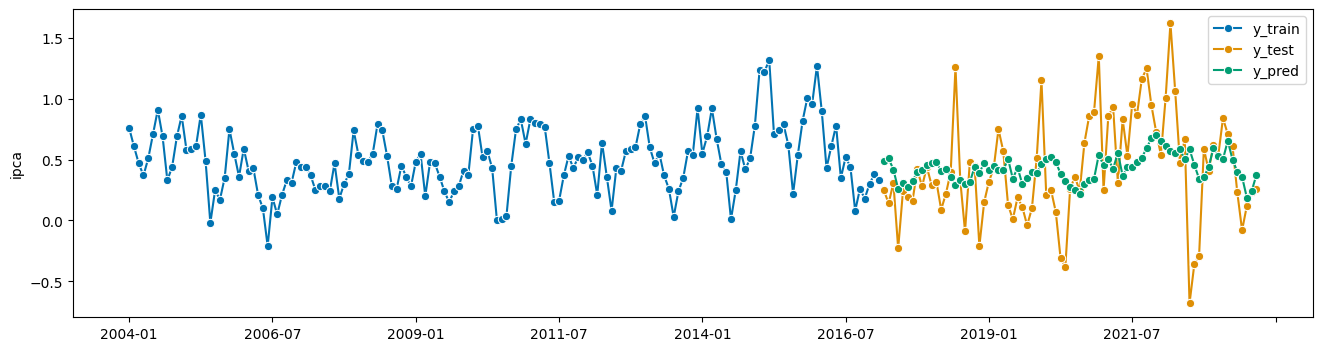

In [7]:
labels = ['y_train', 'y_test', 'y_pred']
fig, ax = plot_series(y_train, y_test, y_pred, labels=labels)

In [8]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_true=y_test, y_pred=y_pred)

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sktime\performance_metrics\forecasting\_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


1.4732561869066654

In [19]:
eval_df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.956000,1.658284,0.038585,158,2017-02,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-03 0.25 Freq: M, Name: ipca, dty...","2017-03 0.489 Freq: M, Name: ipca, dtype: f..."
1,2.647143,1.687241,0.037142,159,2017-03,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-04 0.14 Freq: M, Name: ipca, dty...","2017-04 0.5106 Freq: M, Name: ipca, dtype: ..."
2,0.349032,1.673327,0.037512,160,2017-04,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-05 0.31 Freq: M, Name: ipca, dty...","2017-05 0.4182 Freq: M, Name: ipca, dtype: ..."
3,2.124783,1.681572,0.038687,161,2017-05,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-06 -0.23 Freq: M, Name: ipca, dty...","2017-06 0.2587 Freq: M, Name: ipca, dtype: ..."
4,0.268333,1.697222,0.035808,162,2017-06,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-07 0.24 Freq: M, Name: ipca, dty...","2017-07 0.3044 Freq: M, Name: ipca, dtype: ..."
...,...,...,...,...,...,...,...,...
74,0.740870,3.029884,0.035576,232,2023-04,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-05 0.23 Freq: M, Name: ipca, dty...","2023-05 0.4004 Freq: M, Name: ipca, dtype: ..."
75,5.468750,2.873951,0.034221,233,2023-05,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-06 -0.08 Freq: M, Name: ipca, dty...","2023-06 0.3575 Freq: M, Name: ipca, dtype: ..."
76,0.562500,2.816825,0.042976,234,2023-06,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-07 0.12 Freq: M, Name: ipca, dty...","2023-07 0.1875 Freq: M, Name: ipca, dtype: ..."
77,0.046957,2.873729,0.035863,235,2023-07,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-08 0.23 Freq: M, Name: ipca, dty...","2023-08 0.2408 Freq: M, Name: ipca, dtype: ..."


In [20]:
eval_df['test_MeanAbsolutePercentageError'].mean()

1.4732561869066654

In [21]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_true=y_test, y_pred=y_pred)

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sktime\performance_metrics\forecasting\_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


0.16331309974683544

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_true=y_test, y_pred=y_pred)

In [9]:
fig.savefig("imagens/RF1.png")

Experimenta rodar sem lags

Replica os passos da tentativa anterior

In [10]:
no_lags = {}
no_lags['df'] = pd.read_csv("dados/dados_transformados.csv", sep=";", decimal=",", thousands=".")
no_lags['df'] = utils.index_to_period(no_lags['df'])
no_lags['df']

,ipca,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,...,result_primario,el_nino,epu_br,epu_usa,ind_conf_cons,desemprego,rendimento,crb_cmdt,crb_food,crb_metal
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.76,0.68,-0.548387,-11559013.0,-22319905.0,-18028683.0,-17053471.0,-384.95,-0.0735,-0.363,...,2481.49,0.4,49.609174,-2.34359,8.9,14.696341,348.7366,7.70,18.70,15.10
2004-02,0.61,0.90,0.000000,1650795.0,11117714.0,1275340.0,-2131936.0,-96.42,0.0785,1.699,...,29.00,0.3,121.394093,1.00000,-0.8,15.073171,0.0000,10.11,14.74,24.27
2004-03,0.47,0.40,-0.112903,-1575433.0,-1282702.0,300227.0,-4199993.0,387.24,-0.0248,-2.777,...,2375.73,0.2,-166.416169,-5.00000,-10.1,16.078049,-10382.5684,4.04,2.71,10.95
2004-04,0.37,0.21,-0.270430,539382.0,-378329.0,-4736024.0,-2778970.0,-2535.03,0.0005,-1.562,...,-1911.68,0.2,21.276658,-4.00000,-5.3,16.454878,-339.4192,-0.45,6.35,-11.13
2004-05,0.51,0.54,-0.116667,1252881.0,13051576.0,26890443.0,11143701.0,-62.56,0.1944,4.213,...,1488.90,0.2,14.892162,17.00000,16.2,15.324390,238.2590,-5.31,-15.02,8.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,0.23,0.51,0.000000,-23521679.0,37144204.0,-60304921.0,-53107060.0,3903.44,-0.0369,-0.740,...,-17179.69,0.5,-66.227511,40.00000,-2.9,8.300000,658.0000,-6.00,4.55,-69.98
2023-06,-0.08,0.04,0.000000,10468536.0,35565946.0,178689253.0,102168255.0,9751.93,-0.1312,-0.920,...,-63293.21,0.8,31.459478,-26.00000,3.1,8.000000,2543.0000,6.38,11.08,5.69
2023-07,0.12,-0.07,0.000000,28855151.0,-22727138.0,-55577408.0,-34962544.0,3855.98,-0.0508,0.410,...,-56249.84,1.1,-35.572412,-46.00000,-0.8,7.900000,2429.0000,16.02,23.65,28.36


In [11]:
no_lags['y'] = no_lags['df']['ipca']
no_lags['X'] = no_lags['df'].drop(columns=['ipca'])
no_lags['y_train'], no_lags['y_test'], no_lags['X_train'], no_lags['X_test'] = \
    temporal_train_test_split(y, X, test_size=79)

In [12]:
no_lags['X']

,ipca_15,selic,m1,m2,m3,m4,ibovespa,cambio,cambio_real,ind_varejo,...,result_primario,el_nino,epu_br,epu_usa,ind_conf_cons,desemprego,rendimento,crb_cmdt,crb_food,crb_metal
month,,,,,,,,,,,,,,,,,,,,,
2004-01,0.68,-0.548387,-11559013.0,-22319905.0,-18028683.0,-17053471.0,-384.95,-0.0735,-0.363,-7.19247,...,2481.49,0.4,49.609174,-2.34359,8.9,14.696341,348.7366,7.70,18.70,15.10
2004-02,0.90,0.000000,1650795.0,11117714.0,1275340.0,-2131936.0,-96.42,0.0785,1.699,-0.78942,...,29.00,0.3,121.394093,1.00000,-0.8,15.073171,0.0000,10.11,14.74,24.27
2004-03,0.40,-0.112903,-1575433.0,-1282702.0,300227.0,-4199993.0,387.24,-0.0248,-2.777,1.53498,...,2375.73,0.2,-166.416169,-5.00000,-10.1,16.078049,-10382.5684,4.04,2.71,10.95
2004-04,0.21,-0.270430,539382.0,-378329.0,-4736024.0,-2778970.0,-2535.03,0.0005,-1.562,0.13157,...,-1911.68,0.2,21.276658,-4.00000,-5.3,16.454878,-339.4192,-0.45,6.35,-11.13
2004-05,0.54,-0.116667,1252881.0,13051576.0,26890443.0,11143701.0,-62.56,0.1944,4.213,1.09641,...,1488.90,0.2,14.892162,17.00000,16.2,15.324390,238.2590,-5.31,-15.02,8.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,0.51,0.000000,-23521679.0,37144204.0,-60304921.0,-53107060.0,3903.44,-0.0369,-0.740,1.75850,...,-17179.69,0.5,-66.227511,40.00000,-2.9,8.300000,658.0000,-6.00,4.55,-69.98
2023-06,0.04,0.000000,10468536.0,35565946.0,178689253.0,102168255.0,9751.93,-0.1312,-0.920,-2.28240,...,-63293.21,0.8,31.459478,-26.00000,3.1,8.000000,2543.0000,6.38,11.08,5.69
2023-07,-0.07,0.000000,28855151.0,-22727138.0,-55577408.0,-34962544.0,3855.98,-0.0508,0.410,3.11000,...,-56249.84,1.1,-35.572412,-46.00000,-0.8,7.900000,2429.0000,16.02,23.65,28.36


In [13]:
no_lags['regressor'] = RandomForestRegressor(max_features="sqrt")
fh = ForecastingHorizon(1, is_relative=True)
no_lags['forecaster'] = make_reduction(no_lags['regressor'])

In [14]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=y_train.size)
no_lags['eval'] = evaluate(
    forecaster=no_lags['forecaster'],
    cv=cv,
    y=no_lags['y'],
    X=no_lags['X'],
    strategy="refit",
    return_data=True
)

In [15]:
no_lags['y_pred'] = pd.Series([value[0] for _, value in no_lags['eval']['y_pred'].items()])
no_lags['y_pred'].index = no_lags['y_test'].index
no_lags['y_pred']

C:\Users\asfra\AppData\Local\Temp\ipykernel_10640\1604661032.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_lags['y_pred'] = pd.Series([value[0] for _, value in no_lags['eval']['y_pred'].items()])


month
2017-03    0.4673
2017-04    0.4088
2017-05    0.3727
2017-06    0.2329
2017-07    0.2897
            ...  
2023-05    0.5279
2023-06    0.3802
2023-07    0.2475
2023-08    0.3023
2023-09    0.3260
Freq: M, Length: 79, dtype: float64

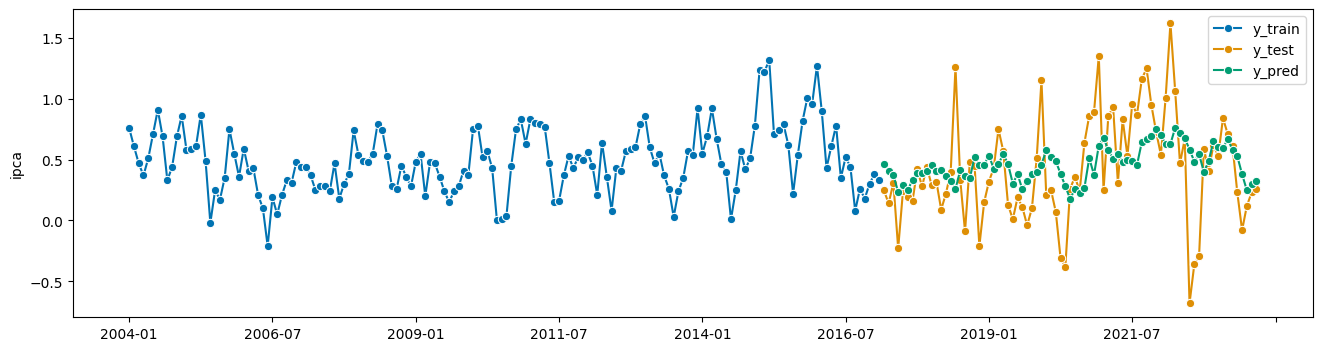

In [16]:
labels = ['y_train', 'y_test', 'y_pred']
fig, ax = plot_series(no_lags['y_train'], no_lags['y_test'], no_lags['y_pred'], labels=labels)

In [17]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_true=no_lags['y_test'], y_pred=no_lags['y_pred'])

C:\Users\asfra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sktime\performance_metrics\forecasting\_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


1.4273412310258786

In [18]:
no_lags['eval']

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.869200,0.594752,0.011189,158,2017-02,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-03 0.25 Freq: M, Name: ipca, dty...","2017-03 0.4673 Freq: M, Name: ipca, dtype: ..."
1,1.920000,0.595870,0.010605,159,2017-03,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-04 0.14 Freq: M, Name: ipca, dty...","2017-04 0.4088 Freq: M, Name: ipca, dtype: ..."
2,0.202258,0.554136,0.012137,160,2017-04,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-05 0.31 Freq: M, Name: ipca, dty...","2017-05 0.3727 Freq: M, Name: ipca, dtype: ..."
3,2.012609,0.558509,0.010955,161,2017-05,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-06 -0.23 Freq: M, Name: ipca, dty...","2017-06 0.2329 Freq: M, Name: ipca, dtype: ..."
4,0.207083,0.561020,0.011590,162,2017-06,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2017-07 0.24 Freq: M, Name: ipca, dty...","2017-07 0.2897 Freq: M, Name: ipca, dtype: ..."
...,...,...,...,...,...,...,...,...
74,1.295217,0.889918,0.010561,232,2023-04,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-05 0.23 Freq: M, Name: ipca, dty...","2023-05 0.5279 Freq: M, Name: ipca, dtype: ..."
75,5.752500,0.887332,0.011103,233,2023-05,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-06 -0.08 Freq: M, Name: ipca, dty...","2023-06 0.3802 Freq: M, Name: ipca, dtype: ..."
76,1.062500,0.877147,0.010312,234,2023-06,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-07 0.12 Freq: M, Name: ipca, dty...","2023-07 0.2475 Freq: M, Name: ipca, dtype: ..."
77,0.314348,0.917015,0.016232,235,2023-07,month 2004-01 0.76 2004-02 0.61 2004-03 ...,"month 2023-08 0.23 Freq: M, Name: ipca, dty...","2023-08 0.3023 Freq: M, Name: ipca, dtype: ..."
